In [1]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
from datetime import datetime
import time
from selenium import webdriver
import math
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.image as mpimg
from sklearn import preprocessing
from PIL import Image


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Loading data / general functions

In [3]:
data = pd.read_csv('devices.csv', index_col='Unnamed: 0')

In [4]:
def get_soup_from_url(url):
    """This function gets an url and returns a bs4 soup"""
    
    headers = {
            'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
        }
    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.content)
    return soup

## PCA

**dropping NaNs for quick PCA**

Now, the column with most missings has 6% of missing values, so it might be ok do drop those...

In [5]:
print('numero de aparelhos antes do drop: ', data.shape[0])
data = data.dropna()
# Dropping any value that is higher than 20k (there is a promo, as of 21-05-2020, of a SMARTPHONE AND SMARTTV PROMO which is
# 40k, and will only hinder efficacy.
data = data.drop(data.loc[data.menor_preco > 20000].index)
print('numero de aparelhos depois do drop: ', data.shape[0])

numero de aparelhos antes do drop:  1224
numero de aparelhos depois do drop:  1116


In [6]:
marcas = ['ios', 'wind', 'brand','android']
X = data.drop(columns=['modelo_celular', 'link_anuncio','menor_preco']+marcas)
# X = data.loc[:,['data_anuncio', 'tela','camera traseira', 'camera selfie', 'nfc', 'memoria interna','android', 'ios', 'brand']]
X = pd.get_dummies(X, prefix='prop_')

Now, we can apply PCA tecnique to help us see all columns as two variables. This will improve analysis and see how people are distanced...

In [7]:
# def pca_fit():
X = X
n_components = 2
# instantiate and fit the pca object
X_std = StandardScaler().fit_transform(X)
# X_std = X

pca = PCA(n_components)
pca.fit(X_std)

print(f'each pca explains: {pca.explained_variance_ratio_}')
explains = pca.explained_variance_ratio_.sum()
print(f'Both components explain together {round(explains*100,2)}% of the data')

#now transform!
X_pca = pca.transform(X_std)

#check results
print("\noriginal shape:   ", X.shape)
print("\ntransformed shape:", X_pca.shape)
pc1 = X_pca[:,0]
pc2 = X_pca[:,1]

each pca explains: [0.14772796 0.09442218]
Both components explain together 24.22% of the data

original shape:    (1116, 39)

transformed shape: (1116, 2)


In [16]:
c = data.modelo_celular.apply(lambda x: 'blue' if 'iphone' in x \
                                          else ('red' if 'samsung' in x \
                                                else ('green' if 'huawei' in x \
                                                      else ('black' if 'motorola' in x else 'yellow'))))

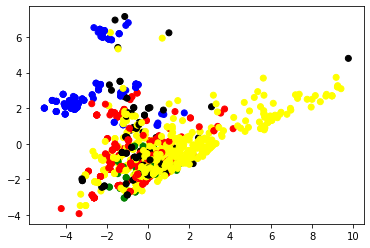

In [17]:
# c = np.array(data.ios.apply(lambda x: 'blue' if x != 0 else 'red'))
# c = data.modelo_celular.apply(lambda x: 'blue' if 'iphone' in x else ('red' if 'samsung' in x else 'yellow'))
plt.scatter(x=pc1, y=pc2, c=c)

- We will also create a function for ploting Kmeans using different number of clusters

In [10]:
len(data.loc[:,'camera traseira'].unique())

27

## KMeans

## Evaluating the ideal number of clusters

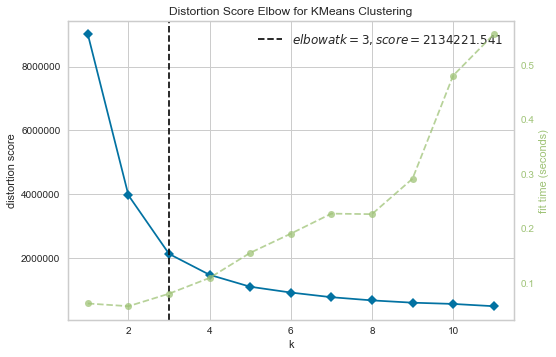

In [11]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans() 
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### CLustering:  dividing all smartphones in groups of 4

In [11]:
#making clusters of somewhat 5 smartphones
n_clusters = 3 #round(X.shape[0]/5)

kmeans = KMeans(n_clusters, n_init=100, random_state=42)

kmeans.fit(X_std)

labels = kmeans.labels_

#add to the dataframe as groups
data['cluster'] = labels + 1

#generate data for plot
pc1 = X_pca[:,0]
pc2 = X_pca[:,1]

c_labels = kmeans.labels_

- Now let us see the results

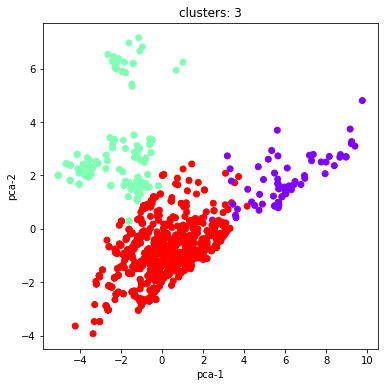

In [12]:
fig, axis = plt.subplots(nrows=1,ncols=1,figsize=(6,6))

axis.scatter(x=pc1, y=pc2, c=c_labels, cmap='rainbow')
axis.set_title(f'clusters: {n_clusters}')
axis.set_xlabel('pca-1')
axis.set_ylabel('pca-2')
plt.show()

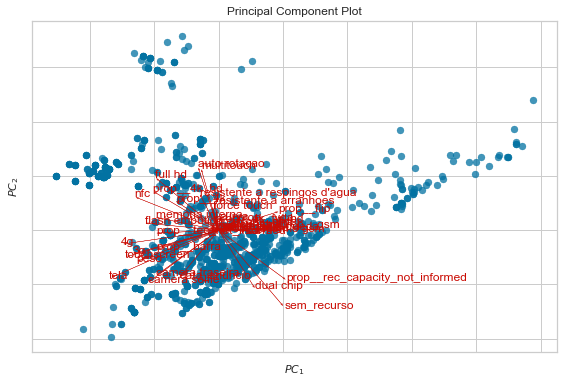

In [14]:
from yellowbrick.features import PCA as PCA_yellow

visualizer = PCA_yellow(scale=True, proj_features=True)
components = visualizer.fit_transform(X)

# for i, name in enumerate(tofilter):
#     visualizer.ax.annotate(name, (components[i, 0]+0.1, components[i, 1]-.1))


visualizer.show()

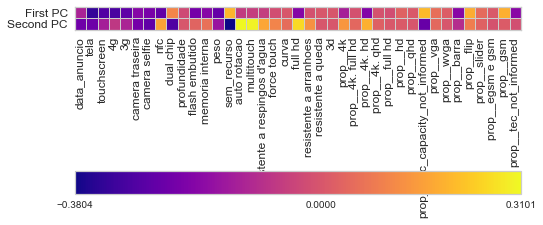

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(X.columns)

ax.set_xticks(np.arange(-.5, len(feature_names)));
ax.set_yticks(np.arange(0.5, 2));
ax.set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
ax.set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()], pad=0.65);

In [16]:
# # t-SNE
# from sklearn.manifold import TSNE
 
# X, y = X,labels
 
# fig, ax = plt.subplots(1, 4, figsize=(15, 7))
# for i, perp in enumerate([30, 50, 100]):
#     tsne = TSNE(perplexity=perp)
#     x_embedded = tsne.fit_transform(X)
#     ax[i].scatter(x_embedded[:, 0], x_embedded[:, 1], c=y)
#     ax[i].set_title("Perplexity = {}".format(perp))
    
# plt.show()

### Preparing data for User input

Adding mean price values of each cluster to the results

In [17]:
#store it in a csv for later use on streamlit
data.to_csv('kmeans_results.csv')

In [18]:
len(data.loc[:,['modelo_celular','menor_preco','link_anuncio','cluster']].loc[:,'cluster'].unique())

223

In [19]:
def clustering_mean_prices(dataset):
    """This function gets the results, calculate the mean prices for each cluster, and returns a dataframe of results
    that will be used to determine the best cluster (or closest cluster)"""
    results = dataset.loc[:,['modelo_celular','menor_preco','link_anuncio','cluster']]
    clusters = results.groupby(by='cluster').mean().reset_index()

    # add cluster mean to the results
    cluster_mean_price = {}
    n_clusters = results.loc[:,'cluster'].unique()
    for cluster in n_clusters:
        cluster_mean_price[cluster] = round(clusters.loc[clusters.loc[:,'cluster'] == cluster].loc[:,'menor_preco'].values[0],2)

    # adding mean price for each cluster
    results['c_mean_price'] = results.loc[:,'cluster'].apply(lambda x: cluster_mean_price[x])

    return results

In [20]:
results = clustering_mean_prices(dataset=data)

## Testing with a search value

### **Strategy here:**

- Get user input
- Check which cluster has the mean value closest to the user input, by calculating the value distance of the cluster mean price for the user input. The shortest distance wins.
- Inside the cluster, do the same process, but now for each smartphone.

In [21]:
# user input
usr = 1000

### **Searching for the closest and cheapest choice of the user**

In [22]:
def winner_cluster(results, usr):
    """This function receives the results dataframe and the user input (usr) and returns the 
    cluster with closest mean prices to the user input.
    """
    #check closest cluster
    temp_df = results.copy()
    temp_df['cluster_dist'] = temp_df.loc[:,'c_mean_price'].apply(lambda x: np.sqrt((x-usr)**2))

    #separate this cluster
    closest_cluster = temp_df.loc[temp_df['cluster_dist'] == temp_df['cluster_dist'].min()]

    #get winner smartphone (closest)
    closest_cluster['phone_dist'] = closest_cluster.loc[:,'menor_preco'].apply(lambda x: np.sqrt((x-usr)**2))

    winner = closest_cluster.loc[closest_cluster.phone_dist == closest_cluster.phone_dist.min()]
    
    return winner

In [23]:
#Base
winner = winner_cluster(results, usr)

### **verify if there are more than 1 winner, and select the best**

Ideas (for now, might change later): 
- Select properties: 'data_anuncio', 'tela', '4g', '3g','camera traseira', 'camera selfie', 'nfc', 'memoria interna'.
- standardize each value based on its own columns. (min value will be a 0, max will be 1)
- sum all values from each row, which will give the final score of the smartphone

In [24]:
def select_winner(main_data, winner):
    """This function receives the winner dataframe, and select the winner (or best) smartphone
    and returns the url and price of the best smartphone."""

    if winner.shape[0] >1:
        #Get complete data from winners and filter numeric properties
        colunas_de_desempate = ['data_anuncio', 'tela', '4g', '3g','camera traseira', 'camera selfie', 'nfc', 'memoria interna']
        temp_df = main_data.copy().loc[list(winner.index)].loc[:, colunas_de_desempate]
        temp_df = temp_df.loc[:,~(temp_df.dtypes == object)].drop_duplicates()

        # add score at the end of each df
        x = temp_df.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        temp_df['score'] = pd.DataFrame(x_scaled).sum(axis=1).values

        # filter winner
        winnerindex = temp_df.loc[temp_df.loc[:,'score'] == temp_df.loc[:,'score'].max()].index
        winner = main_data.loc[winnerindex]

    winner_url, winner_price = winner.link_anuncio.values[0], winner.menor_preco.values[0]
    return winner_url, winner_price

In [25]:
winner_url, winner_price = select_winner(main_data=data, winner=winner)

### **Searching for an option which is 20% more expensive butt better**

rules = The suggested smartphone cannot be cheaper than the user input

Ideas (for now, might change later): 
- Same previous hierarchical rules apply here.

In [26]:
#check suggestion for 20% higher price:
suggestion = winner_cluster(results, usr = usr *1.2)
# get the suggested smartphone
suggestion_url, suggestion_price = select_winner(main_data=data, winner=suggestion)

### Join everything in a single function

Idea is:
- receive a value, return se winner and suggestion!

In [27]:
def get_my_smartphone(dataset, money, upper=1.2):
    """This function receives the labeled dataset, an amount of money and returns
    a list of the best fit device's url and price, as well as the url and price
    from a suggested smartphone. The upper"""
    
    #base
    winner = winner_cluster(results=dataset, usr=money)
    winner_url, winner_price = select_winner(main_data=data, winner=winner)
    
    #upper suggestion
    suggestion = winner_cluster(results=dataset, usr=usr*upper)
    
    # get the suggested smartphone
    suggestion_url, suggestion_price = select_winner(main_data=data, winner=suggestion)
                                
    return [winner_url, winner_price, suggestion_url, suggestion_price]

### **Compare winner with suggestion** : do it later

In [28]:
# select important columns
colunas_de_desempate = ['menor_preco','data_anuncio', 'tela', '4g', '3g','camera traseira', 'camera selfie', 'nfc', 'memoria interna']

# merge results in a 2-row-dataframe
final_results = data.loc[list(winner.index) + list(suggestion.index)]

# select only important columns
comparation = final_results.loc[:,colunas_de_desempate]

In [29]:
# add score at the end of each df
x = comparation.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
final_results['score'] = pd.DataFrame(x_scaled).sum(axis=1).values

In [30]:
# Generate final results table
final_results = final_results.loc[:, ['modelo_celular', 'score'] + colunas_de_desempate].dropna(axis=1)

In [31]:
# get parameters where suggestion is better than the winner
math = (final_results.iloc[1,2:] - final_results.iloc[0,2:])/final_results.iloc[1,2:]*100
math = math[math > 0]

# create dictionary of answers:
better = {}
for key, value in zip(math.index, math.values):
    better[key] = str(round(value)) + '%'

## Show the results

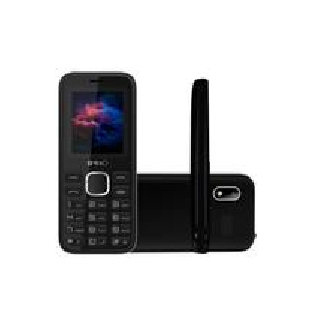

Sua sugestão é:

Celular Ipro A8 Desbloqueado 32MB Dual Chip Preto

Melhor custo/benefício: R$186,00.

Encontre em:

https://www.jacotei.com.br/celular-ipro-a8-desbloqueado-32mb-dual-chip-preto/p


In [32]:
answer = get_my_smartphone(dataset=results, money=300, upper=1.2)
winner_url = answer[0]
winner_price = answer[1]
suggestion_url = answer[2]
suggestion_price  = answer[3]

soup = get_soup_from_url(winner_url)

try: 
    try:
        name = soup.find_all('img', attrs={'class': "principal center-block"})[0]['alt']
    except:
        name = soup.find_all('div', attrs={'class':"image_prod"})[0].find_all('img')[0]['alt']

    try:
        img_url = soup.find_all('img', attrs={'class': "principal center-block"})[0]['data-zoom-image']
    except:
        img_url = soup.find_all('div', attrs={'class':"image_prod"})[0].find_all('img')[0]['data-original']

    response = requests.get(img_url)

    file = open("imagem_celular.png", "wb")
    file.write(response.content)
    file.close()

    image = Image.open('imagem_celular.png')
    imgplot = plt.imshow(image)
    plt.axis('off')
    plt.grid(b=None)

    plt.show()
    
    print('Sua sugestão é:\n')
    print(name)
    print(f'\nMelhor custo/benefício: R${winner_price},00.')
    print('\nEncontre em:\n')
    print(winner_url)

except:
    print('Produto recomendado não disponível!')